In [1]:
using ITensors, ITensorMPS, Plots, LaTeXStrings
using ProgressMeter,Graphs

doubled_gates = Dict(
    "XL" => [0 1 0 0; 1 0 0 0; 0 0 0 -1im; 0 0 1im 0],
    "XR" => [0 1 0 0; 1 0 0 0; 0 0 0 1im; 0 0 -1im 0],
    "XC" => [0 0 0 0; 0 0 0 0; 0 0 0 -2im; 0 0 2im 0],
    "YL" => [0 0 1 0; 0 0 0 1im; 1 0 0 0; 0 -1im 0 0],
    "YR" => [0 0 1 0; 0 0 0 -1im; 1 0 0 0; 0 1im 0 0],
    "YC" => [0 0 0 0; 0 0 0 2im; 0 0 0 0; 0 -2im 0 0],
    "ZL" => [0 0 0 1; 0 0 -1im 0; 0 1im 0 0; 1 0 0 0],
    "ZR" => [0 0 0 1; 0 0 1im 0; 0 -1im 0 0; 1 0 0 0],
    "ZC" => [0 0 0 0; 0 0 -2im 0; 0 2im 0 0; 0 0 0 0],
    "IL" => [1 0 0 0; 0 1 0 0; 0 0 1 0; 0 0 0 1],
    "IR" => [1 0 0 0; 0 1 0 0; 0 0 1 0; 0 0 0 1],
    "IC" => [0 0 0 0; 0 0 0 0; 0 0 0 0; 0 0 0 0],
    "MD" => [0 0 0 -2; 0 -1 0 0; 0 0 -1 0; 0 0 0 -2],
    "PD" => [0 0 0 0; 0 -1 0 0; 0 0 -1 0; 0 0 0 -1],
);

## dynamics stuff

In [2]:
function pair_to_index_folded(i, j)
    return (i - 1) * 4 + j
end

function get_itensor_folded(gate,i1_in,i2_in,i1_out,i2_out)
    U_tensor = ITensor(i1_in,i2_in,i1_out,i2_out)
    for i1_out_val in 1:4, i2_out_val in 1:4, i1_in_val in 1:4, i2_in_val in 1:4
        row = pair_to_index_folded(i1_out_val, i2_out_val)
        col = pair_to_index_folded(i1_in_val, i2_in_val)
        U_tensor[i1_out => i1_out_val, i2_out => i2_out_val,
                 i1_in => i1_in_val, i2_in => i2_in_val] = gate[row, col]
    end
    return U_tensor
end 

function operator_dynamics(N,T,bitstring_initial,bitstring_final)
    δt = 0.05
    hamil = (kron(doubled_gates["XL"],doubled_gates["XL"]) - kron(doubled_gates["XR"],doubled_gates["XR"]))
    hamil+= (kron(doubled_gates["YL"],doubled_gates["YL"]) - kron(doubled_gates["YR"],doubled_gates["YR"]))
    hamil+= (kron(doubled_gates["ZL"],doubled_gates["ZL"]) - kron(doubled_gates["ZR"],doubled_gates["ZR"]))
    gate = exp(-1im*δt*hamil)
    indmat = [Index(4, "x$(i)t$(j)") for i in 1:N, j in 0:T]
    χ = 4
    tensors = []

    for x = 1 : N 
        tens = ITensor(indmat[x,1])
        tens[indmat[x,1] => bitstring_initial[x] + 1] = 1 ## set initial pauli string conditions
        push!(tensors,tens)
    end 

    for t = 1 : T 
        if t % 2 == 1
            for x = 1 : 2 : N 
                tens = get_itensor_folded(gate,indmat[x,t],indmat[x+1,t],indmat[x,t+1],indmat[x+1,t+1])
                push!(tensors,tens)
            end 
        else
            for x = 2 : 2 : N-1
                tens = get_itensor_folded(gate,indmat[x,t],indmat[x+1,t],indmat[x,t+1],indmat[x+1,t+1])
                push!(tensors,tens)
            end 
            ten1 = delta(indmat[1,t],indmat[1,t+1])
            ten2 = delta(indmat[N,t],indmat[N,t+1])
            push!(tensors,ten1,ten2)
        end 
    end 

    for x = 1 : N 
        tens = ITensor(indmat[x,end])
        tens[indmat[x,end] => bitstring_final[x] + 1] = 1 
        push!(tensors,tens)
    end 
    return tensors 
end 


operator_dynamics (generic function with 1 method)

## BP stuff

In [3]:
function get_adj_mat(tensors)
    n = length(tensors)
    adj_mat = zeros(Int32, n, n)  # Initialize n x n zero matrix
    edges = Tuple{Int,Int}[]      # Initialize edge list
    links = []
    for i in 1:n
        for j in (i+1):n  # Avoid duplicate checks and self-loops
            if !isempty(commoninds(tensors[i], tensors[j]))
                adj_mat[i,j] = 1
                adj_mat[j,i] = 1  # Symmetric connection
                push!(edges, (i,j)) ## i < j convention
                @assert length(commoninds(tensors[i], tensors[j])) == 1 "Expected to have only one common index."
                push!(links,commoninds(tensors[i], tensors[j])[1])
            end
        end
    end
    return adj_mat, edges, links
end

function get_nbrs(adj_mat, v)
    row = adj_mat[v, :]
    return findall(x -> x == 1, row)
end

function get_messages(tensors,edges,links)
    ## N: number of vertices in the tensor network
    ## links: list of indices corresponding to edges in the tensor network
    ## edges: list of  (v1,v2) edges with convention v1 < v2 
    n = length(tensors)
    messages = Array{ITensor}(undef,n,n)
    for (e, edge) in enumerate(edges) 
        v1, v2 = edge 
        index = links[e]
        dimension = dim(index)
        messages[v1, v2] = delta(ComplexF64, index) / sqrt(dimension)
        messages[v2, v1] = delta(ComplexF64, index) / sqrt(dimension) 
    end 
    return messages
end 

function message_passing(tensors,messages,edges,links,adj_mat)
    ## tensors: tensor network 
    ## messages: matrix of message tensors {μ[v1,v2]}
    ## links: list of indices corresponding to edges in the tensor network
    ## edges: list of (v1,v2) edges with convention v1 < v2 
    Δ = 100 
    while Δ > 1e-6
        
        δ = 0 
        for e in edges 
            ## want to update the message from v1 → v2 
            v1, v2 = e 
            update = tensors[v1]
            for nbr in get_nbrs(adj_mat, v1)
                if nbr != v2 
                    update = update * messages[nbr,v1]
                end
            end 
            # println(check_permutation_indices(messages[v1,v2],update))
            δ += norm(messages[v1,v2] - update/norm(update))
            messages[v1,v2] = update/norm(update)
        end 
        
        # backward
        
        for e in edges 
            ## want to update the message from v1 → v2 
            v2, v1 = e 
            update = tensors[v1]
            for nbr in get_nbrs(adj_mat, v1)
                if nbr != v2 
                    update = update * messages[nbr,v1] 
                end
            end 
            # println(check_permutation_indices(messages[v1,v2],update))
            δ += norm(messages[v1,v2] - update/norm(update))
            messages[v1,v2] = update/norm(update)
        end   
        Δ = δ  
    end 
    return messages 
end 

function mean_free_partition_fn(these_vertices,tensors,messages,edges,links,adj_mat)
    ## computes the fixed point partition function at the vertices specified by these_vertices 
    ## other things as usual, these_vertices = 1:N gives the BP fixed point
    Z = 1 
    for index = these_vertices
        nbrs = get_nbrs(adj_mat, index)
        Z_local = tensors[index] 
        for nbr in nbrs
            Z_local *= messages[nbr,index] 
        end
        @assert isempty(inds(Z_local))  "tensors[$index] must be a scalar"
        Z *= scalar(Z_local)
    end
    return Z # -log(Z)/(L^2)
end 


function excited_edge(edge,messages,edges,links,adj_mat)
    ## gives the excited projector on the specified edge
    v1,v2 = edge
    edge_index = findfirst(e -> e == edge, edges)
    index = links[edge_index]
    iden = ITensor(index,prime(index)) 
    for n in 1:dim(index)
        iden[index=>n, prime(index)=>n] = 1.0 + 0im  # Fill diagonal with ComplexF64 1s
    end
    return iden - prime(messages[v1,v2]) * messages[v2,v1] ## convention: in the excited edge, the daggered index is v1 -> v2 with v1 < v2
                                                           ## so the corresponding index on T[v2] needs to be primed
end 


function loop_contribution(loop,messages,tensors,edges,links,adj_mat)
    ## gives the excited loop contribution to the partition function at the specified loop, and BP solution at all other edges
    ## loop looks like [(v1,v2),(v2,v3) ...] ## MAKE SURE all edges in the loop are oriented such that v1 < v2
    vertices_done = Set()
    loop_contri = 1 
    for edge in loop 
        v1, v2 = edge ### v1 < v2 by convention 
        excitation = excited_edge(edge,messages,edges,links,adj_mat)
        loop_contri *= excitation
        if !(v1 in vertices_done)
            vertices_done = union(vertices_done, v1)
            excited_neighbors = Set([other_vertex for edge in loop if v1 in edge for other_vertex in edge if other_vertex != v1])
            edges_with_v1 = filter(t -> v1 in t, loop)  ## find excited edges with v1
            edge_indices = [findfirst(isequal(t), edges) for t in edges_with_v1] ## find the corresponding indices in edges list 
            larger_bools = [v1 == max(t[1], t[2]) for t in edges_with_v1] ## check if v1 is the larger vertex in the edge, so that we can prime it 
            selected_links = links[edge_indices[larger_bools]] ## thus now we select the links to be primed 
            contri = !isempty(selected_links) ? prime(tensors[v1], selected_links...) : tensors[v1] ## prime the selected links
            loop_contri *= contri
            for w in get_nbrs(adj_mat, v1)
                current_edge = (min(v1,w), max(v1,w))  
                edge_index = findfirst(e -> e == current_edge, edges)
                current_link = links[edge_index]
                if current_link in inds(loop_contri) && !(w in excited_neighbors)
                    loop_contri *= messages[w,v1]  
                end
            end
        end
        if !(v2 in vertices_done)
            vertices_done = union(vertices_done, v2)
            excited_neighbors = Set([other_vertex for edge in loop if v2 in edge for other_vertex in edge if other_vertex != v2])
            edges_with_v2 = filter(t -> v2 in t, loop) 
            edge_indices = [findfirst(isequal(t), edges) for t in edges_with_v2]
            larger_bools = [v2 == max(t[1], t[2]) for t in edges_with_v2]
            selected_links = links[edge_indices[larger_bools]]
            contri = !isempty(selected_links) ? prime(tensors[v2], selected_links...) : tensors[v2]
            loop_contri *= contri 

            for w in get_nbrs(adj_mat, v2)
                current_edge = (min(v2,w), max(v2,w))  
                edge_index = findfirst(e -> e == current_edge, edges)
                current_link = links[edge_index]

                if current_link in inds(loop_contri) && !(w in excited_neighbors)
                    loop_contri *= messages[w,v2]  
                end
            end
    
        end
    end
    return scalar(loop_contri) * mean_free_partition_fn(setdiff(Set(1:N),(vertices_done)),tensors,messages,edges,links,adj_mat)
end

loop_contribution (generic function with 1 method)

## Compute $\langle S_x(0) S_x(t) \rangle$ at $\beta = 0$

In [22]:
N = 24
initial = zeros(Int32, N)
initial[Int(N/2)] = 1
final = zeros(Int32, N)
final[Int(N/2)] = 1

1

In [28]:
ans = []
ts = 1:14
for T in ts
    tensors = operator_dynamics(N,T,initial,final)
    adj_mat, edges, links = get_adj_mat(tensors)
    messages = get_messages(tensors,edges,links) 
    messages = message_passing(tensors,messages,edges,links,adj_mat)
    push!(ans,mean_free_partition_fn(Set(1:length(tensors)),tensors,messages,edges,links,adj_mat))
end 

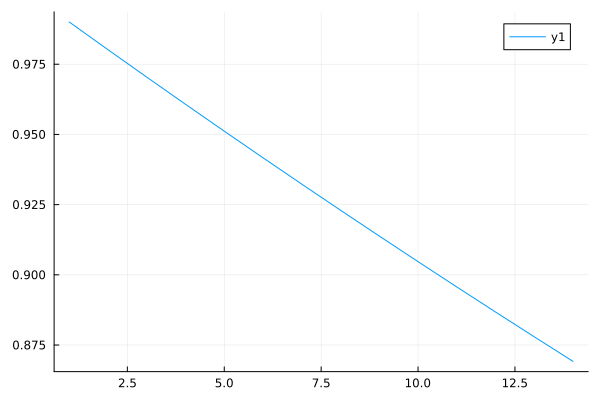

In [26]:
plot(ts,real.(ans))